In [79]:
# python v3.11.8
# import necessary packages

import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('functions')

from greatbrowser import great_analysis

from gene_analysis_functions import get_cistrome, get_pos, insig_nan
from pseudoinverse_functions import pinv_dropmin, quality_filter, trait_cluster, count_cumulative_probes

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Establish the CWD, import relevant data, and perform basic formatting

In [3]:
# set directory, import data, drop undefined
os.chdir('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\raw_data')
#os.chdir('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\raw_data')

data = pd.read_excel('methylation_phenotype_encoded.xlsx', index_col=0) # mm39
data = data.dropna()

# referring to the point in the data where methylation and phenotype data diverge
sep=55

# seperate trait and methylation data
trait_data = data[:sep]
meth_data = data[sep:]

print(f'{trait_data.shape[0]} traits')

55 traits


Scale (not normalize) each row by dividing it by its standard deviation

In [270]:
# avoid scaling the categorical variables
no_categorical = trait_data.drop(['CD1 or C57BL6J?', 'C57BL6J or Sv129Ev?', 'Rank', 'High Fat Diet?'])
no_categorical = no_categorical.T

# divide each row (trait) by its standard deviation
trait_data_std = (no_categorical-no_categorical.mean())/no_categorical.std()

# add the categorical variables back to the dataframe
categorical_vars = trait_data.loc[['CD1 or C57BL6J?', 'C57BL6J or Sv129Ev?', 'Rank', 'High Fat Diet?']]

trait_data_std = trait_data_std.T
trait_data_std = pd.concat([trait_data_std, categorical_vars], axis=0)

Filter the trait data to remove collinearity

In [271]:
filter = 0.70
f_trait_data, masked_corr = quality_filter(trait_data_std, filter)

print(f'{f_trait_data.shape[0]} traits')

19 traits


Show collinearity as a heatmap

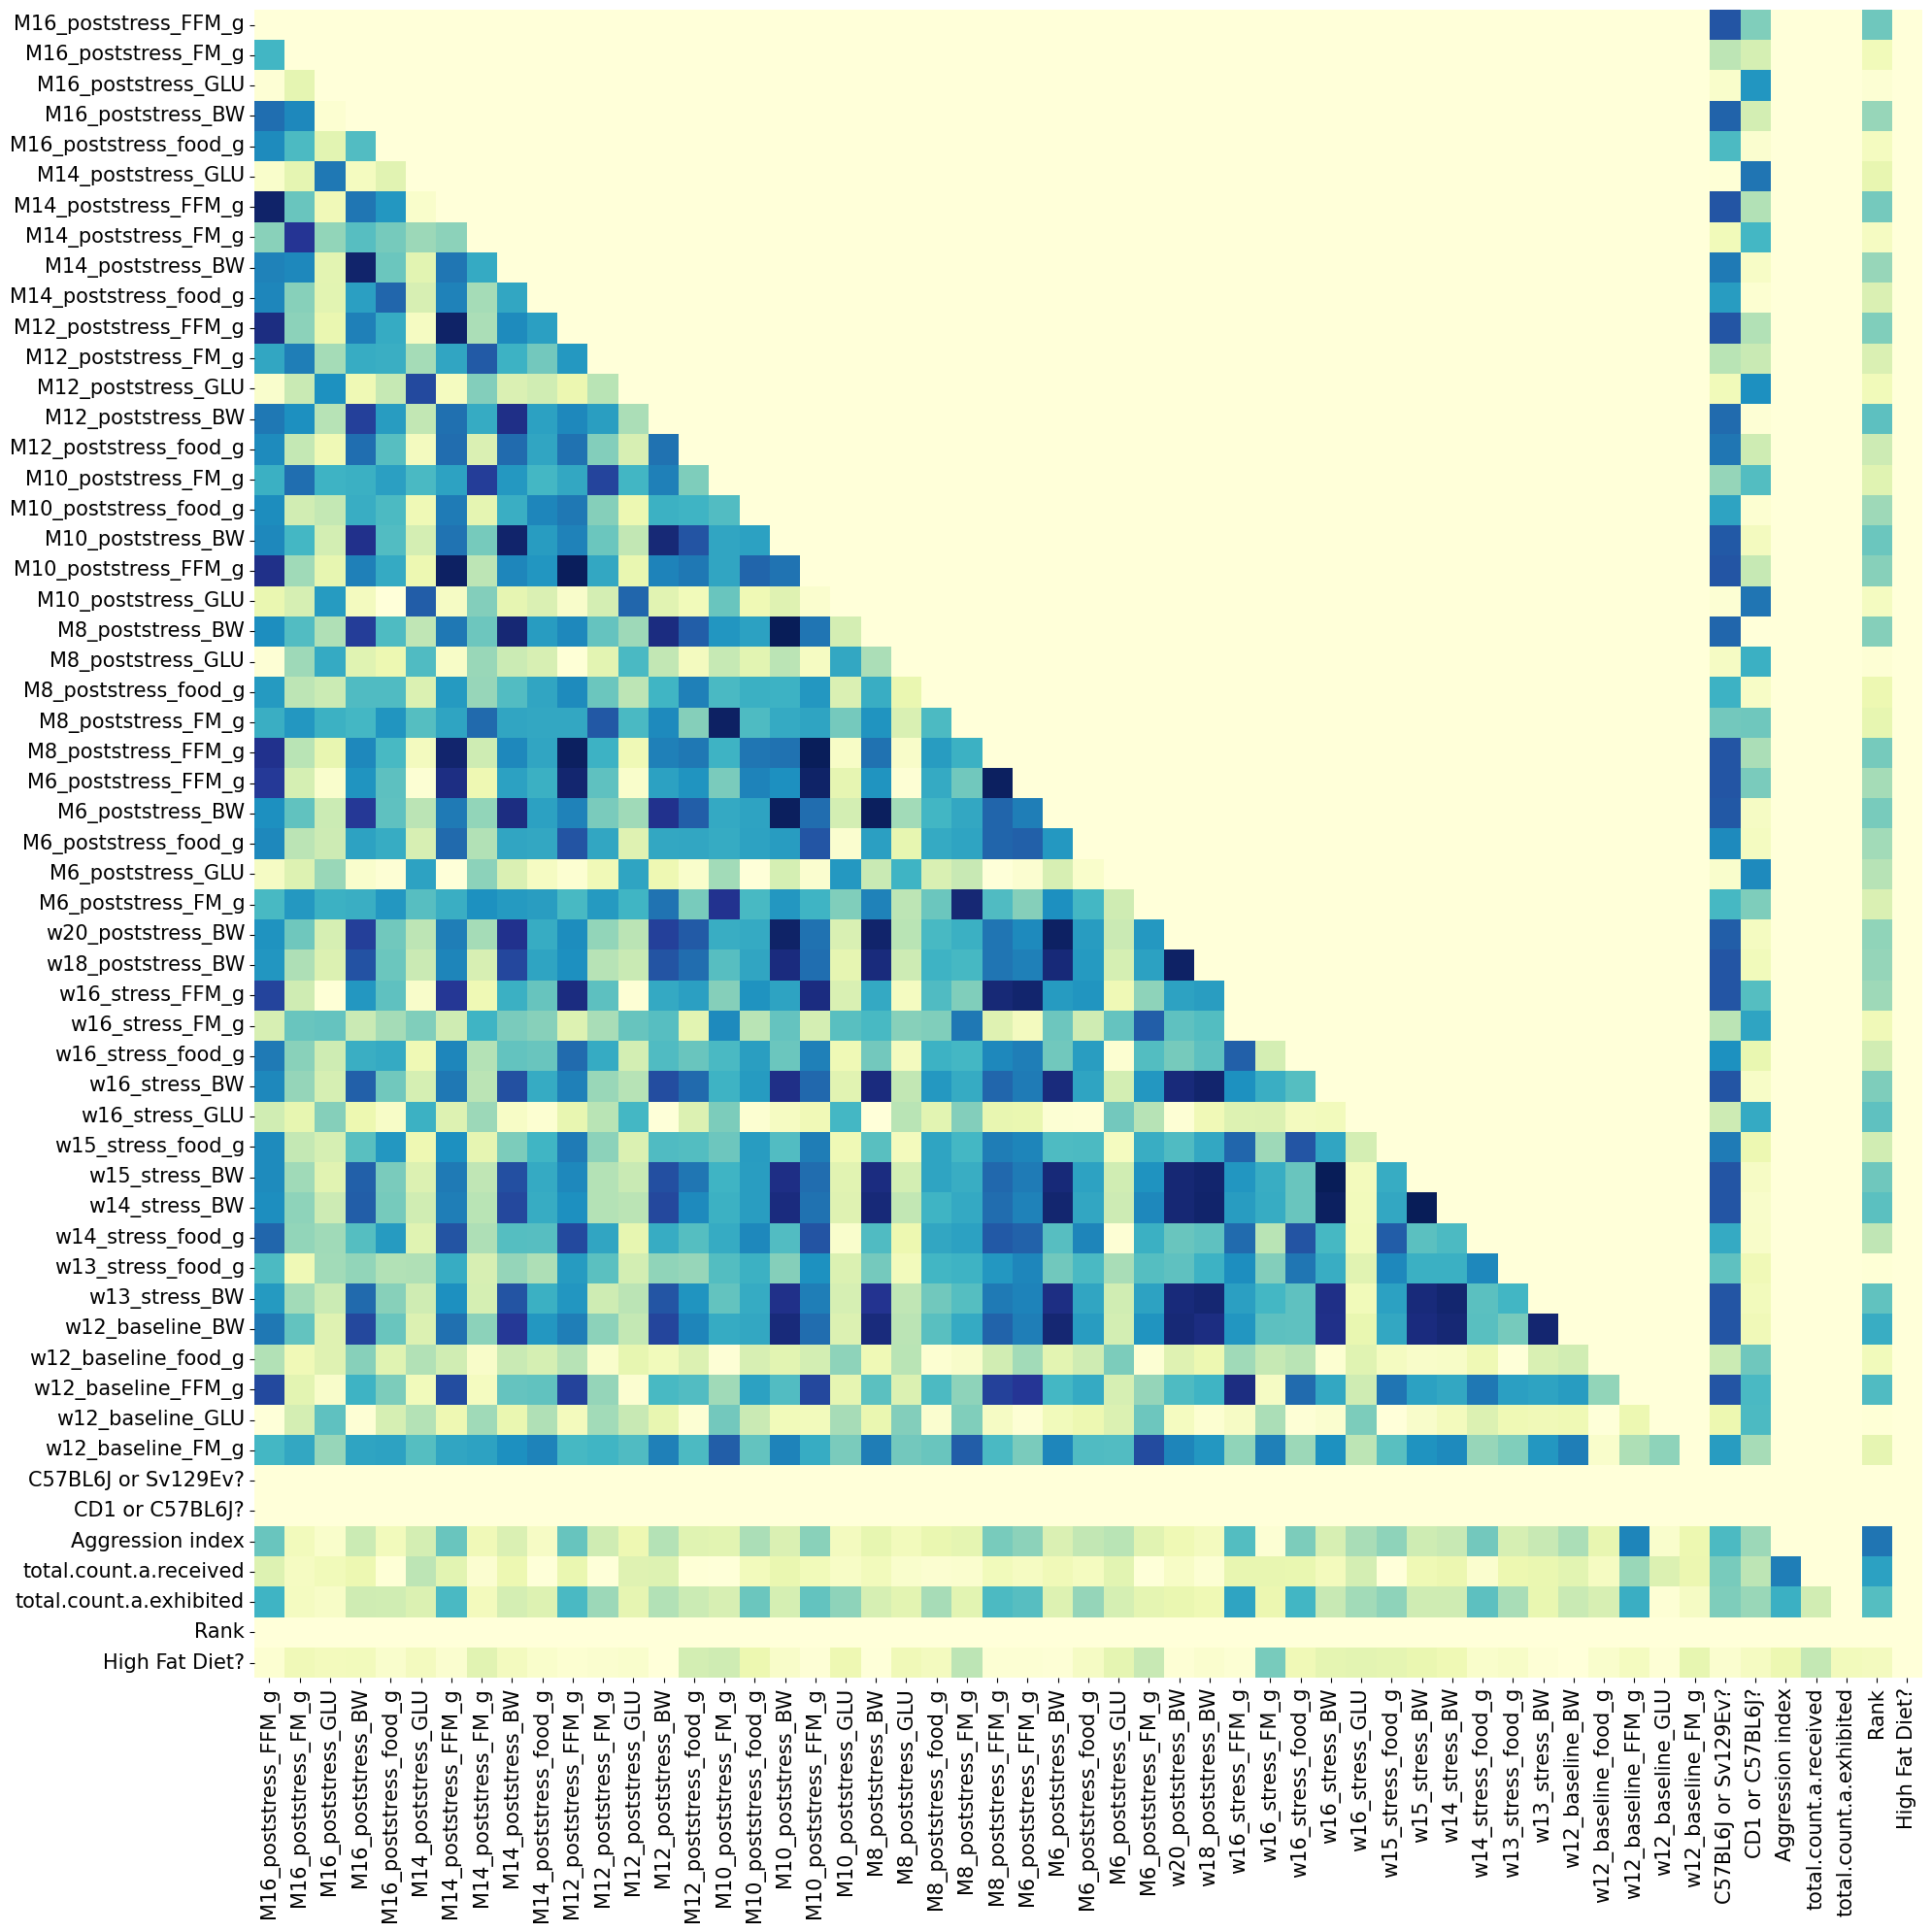

In [275]:
plt.figure(figsize=(20, 20))
sns.heatmap(masked_corr, annot=False, cmap='YlGnBu', cbar=False, square=True)

plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)

plt.tight_layout()

Generate pseudoinversion plots

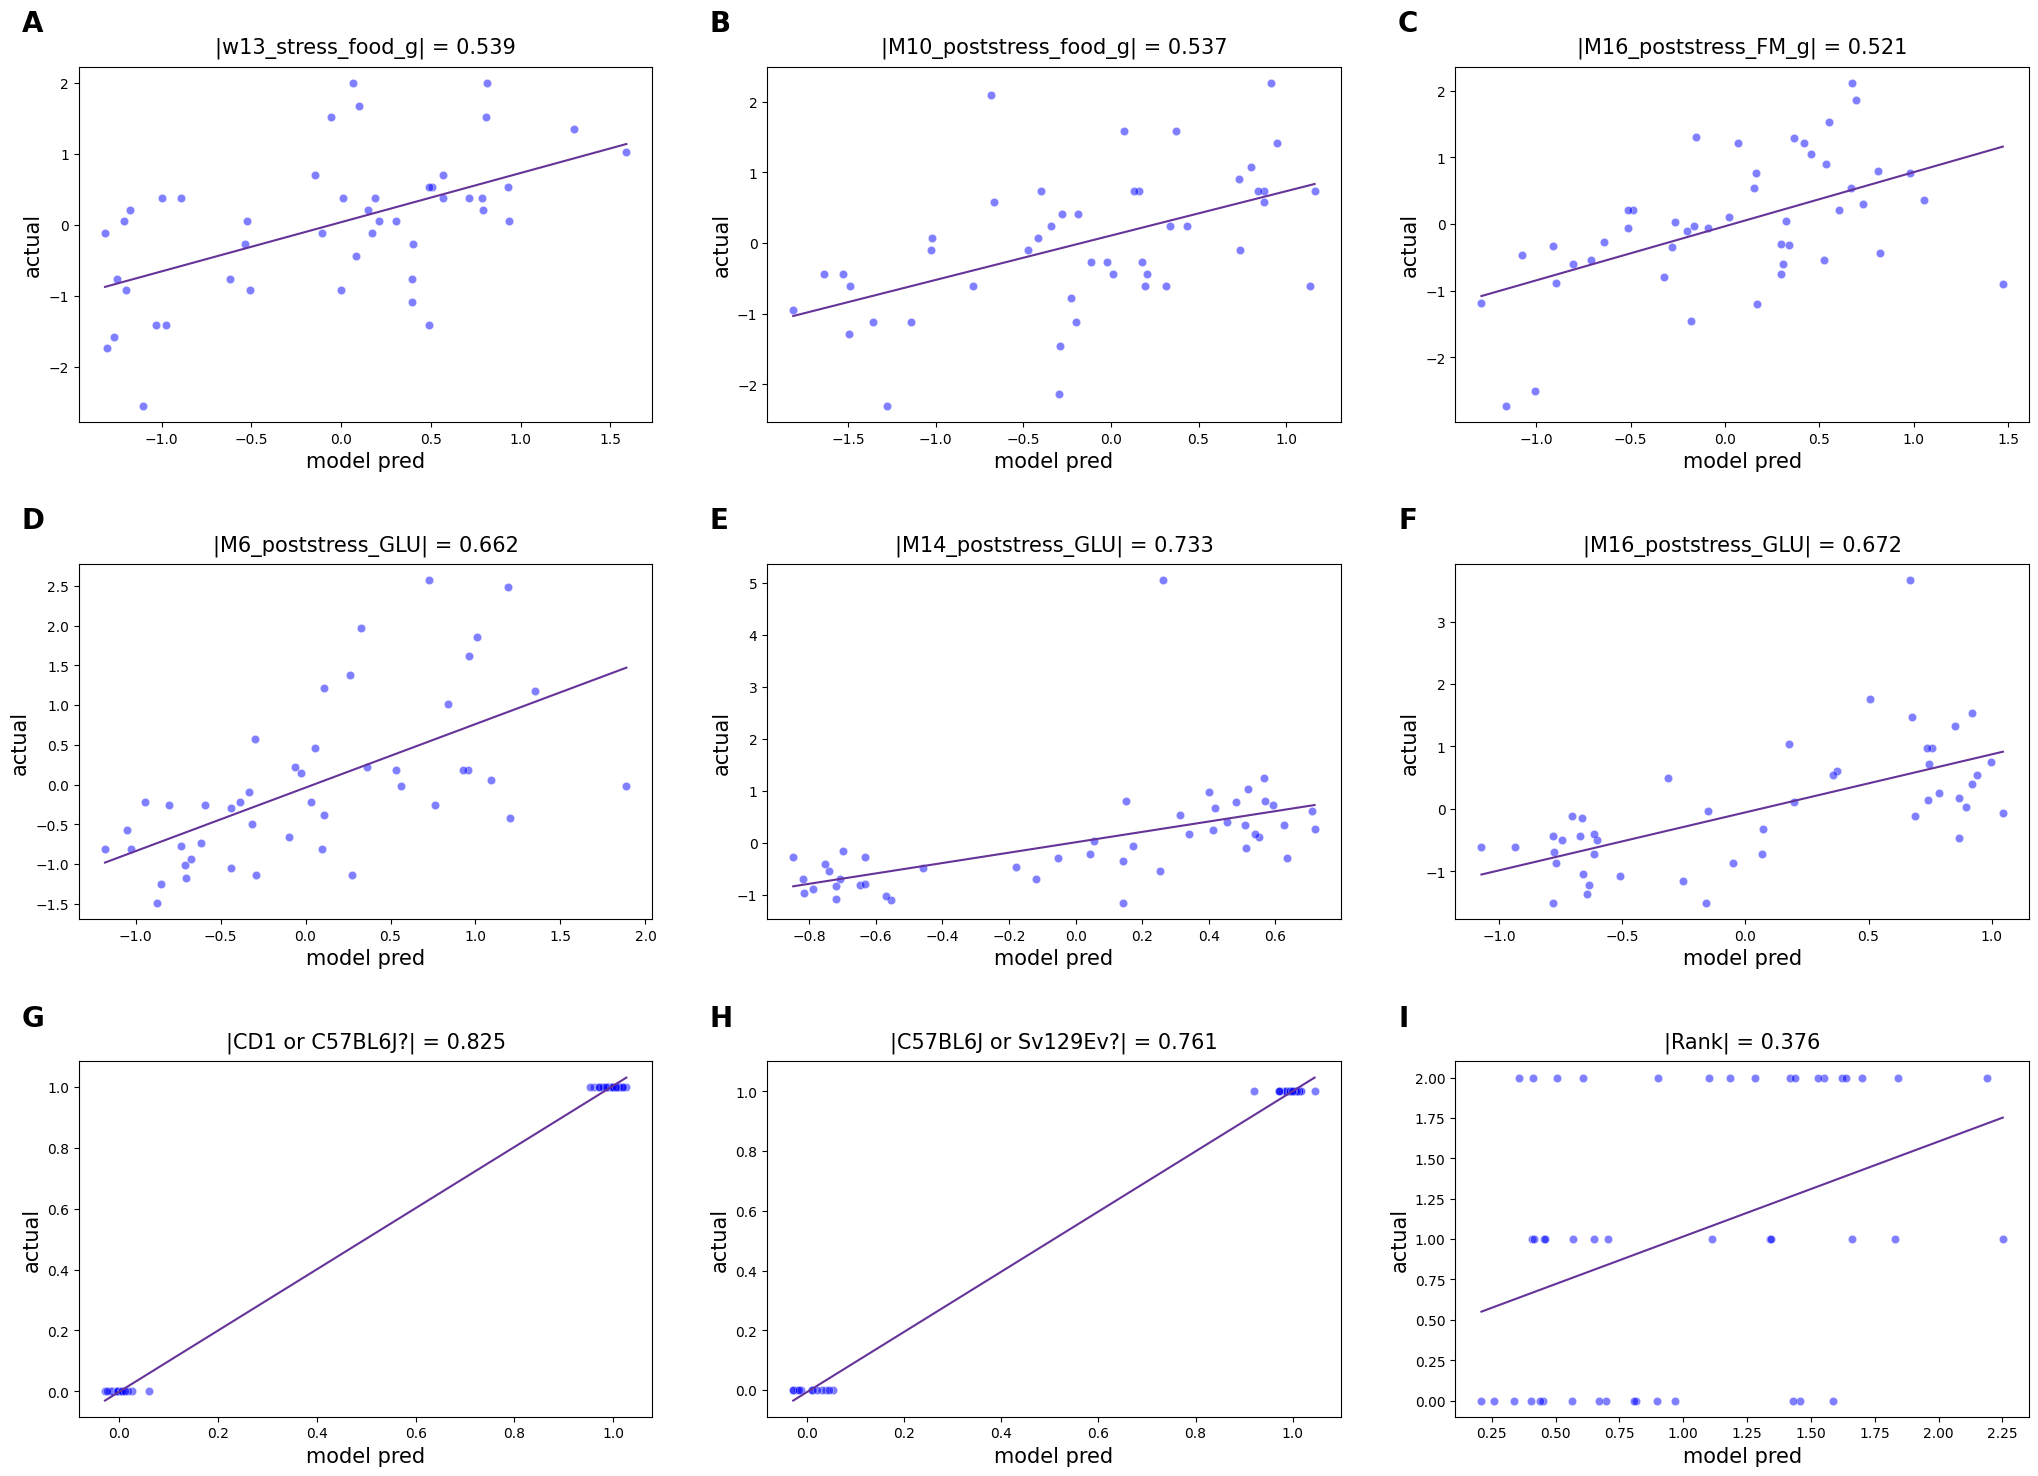

In [266]:
trait_thresh = 0.50
probe_thresh = 0.50
pred, actual, index = pinv_dropmin(f_trait_data, meth_data, trait_thresh, 
             find_meth=False, probe_thresh=probe_thresh);

Create a heatmap showing the prediction accuracy across all traits

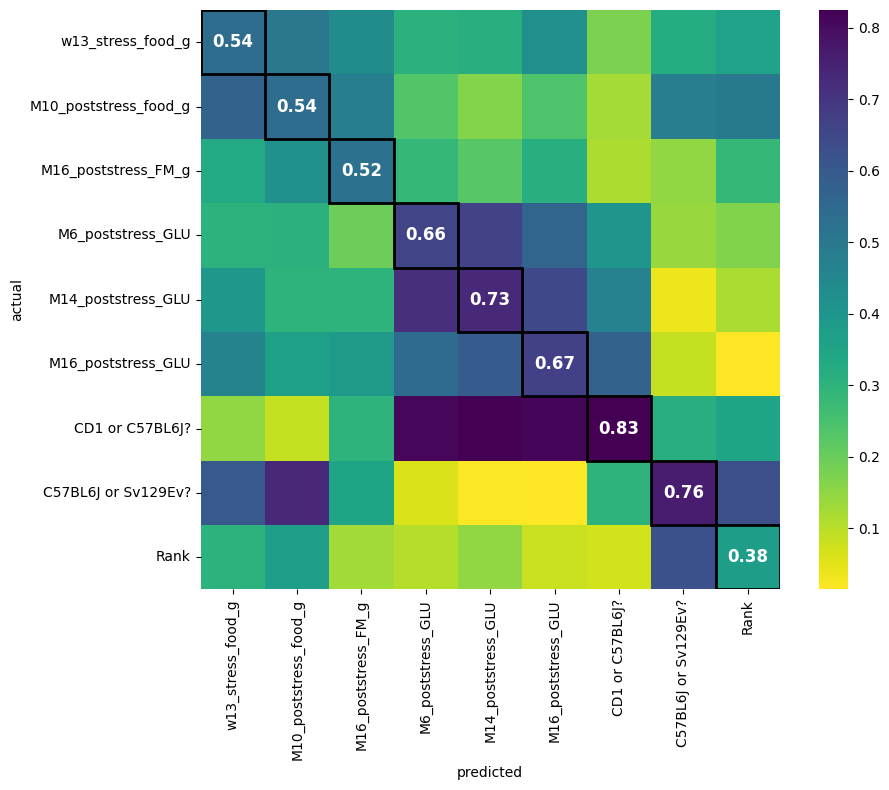

In [268]:
# create df from dict
df_pred = pd.DataFrame(pred) 
df_actual = pd.DataFrame(actual)

# empty df for the correlation results
correlation_results = pd.DataFrame(index=df_actual.columns, columns=df_pred.columns)

# Spearman coef for each combination of keys
for pred_key in df_pred.columns:
    for actual_key in df_actual.columns:
        correlation_results.loc[actual_key, pred_key] = df_pred[pred_key].corr(df_actual[actual_key], method='spearman')

# convert the coef to abs
correlation_matrix = correlation_results.astype(float).abs()

# create the heatmap without annotations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='viridis_r', cbar=True, square=True)

# loop through the df to add annotations and a black box around diagonal elements
for i in range(len(correlation_results)):
    # add diagonal annotations
    plt.text(i + 0.5, i + 0.5, f"{correlation_results.iloc[i, i]:.2f}", 
             ha='center', va='center', color='white', fontsize=12, weight='bold')
    # add a black rectangle around diagonal elements
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, edgecolor='black', facecolor='none', lw=2))

# add titles and labels
plt.xlabel('predicted')
plt.ylabel('actual')
plt.tight_layout()

Generate a heatmap of the probe/trait MMR AdjP values

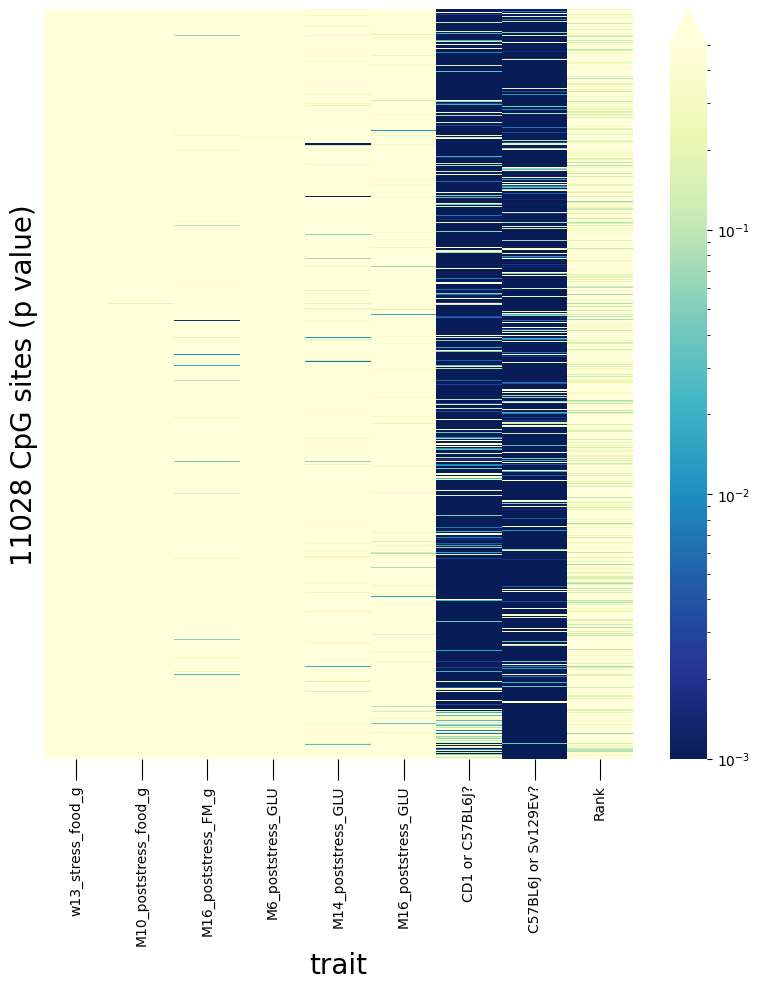

In [269]:
probe_thresh = 0.50
trait_vals, trait_pvals = pinv_dropmin(f_trait_data, meth_data, trait_thresh, 
                                            find_meth=True, plot_results=True, 
                                            probe_thresh=probe_thresh);

Identify the most significant probes and convert from mm39 to mm10

In [263]:
mm39_data = pd.read_excel('mm39_formatted_manifest.xlsx', index_col=0)
probe_df = get_pos(trait_vals, mm39_data);

Find how many mm39s had no equivalent conversion

In [264]:
non_nan_count = trait_vals['pos_mm10'].isna().sum()
print(f'there are {non_nan_count} sites without mm10 equivalents')

trait_mm10_valid = trait_vals.copy()
trait_mm10_valid = trait_mm10_valid.dropna()
trait_mm10_valid

there are 3 sites without mm10 equivalents


,M10_poststress_food_g_pval,M10_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M16_poststress_GLU_pval,M16_poststress_GLU_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,C57BL6J or Sv129Ev?_pval,C57BL6J or Sv129Ev?_coef,Rank_pval,Rank_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10
cg06259996_TC21,0.667604,-0.002874,0.770052,-0.003936,0.951096,-0.000863,0.642491,0.003751,2.019536e-08,-0.045731,1.690670e-11,-0.056750,0.950882,0.000359,chr13,78346406,78346408,chr13,78198287.0,78198289.0
cg07687349_TC21,0.811905,0.001972,0.976663,-0.000534,0.893361,-0.001715,0.843151,0.001863,5.266179e-05,-0.031811,1.505462e-06,-0.036558,0.803784,0.001402,chr2,61635281,61635283,chr2,61804937.0,61804939.0
cg11548411_BC21,0.903017,-0.001248,0.951926,0.001119,0.661122,-0.004515,0.298815,0.007436,4.838340e-11,-0.073356,5.817612e-13,-0.079254,0.960176,0.000353,chr19,45290832,45290834,chr19,45302393.0,45302395.0
cg12044283_TC21,0.708053,-0.008220,0.906992,-0.005165,0.836331,-0.007076,0.919386,-0.003095,8.508937e-03,0.056145,3.318605e-05,-0.087315,0.879536,0.002669,chr19,45318466,45318468,chr19,45330027.0,45330029.0
cg12227830_BC21,0.804010,-0.002764,0.904021,0.002469,0.985825,0.000416,0.786968,0.003414,7.971686e-09,-0.072244,2.486471e-10,-0.076538,0.984714,-0.000163,chr3,133946379,133946381,chr3,134240618.0,134240620.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343860_TC21,0.912060,-0.006896,0.874318,-0.016393,0.716157,0.023770,0.771375,-0.017766,8.542436e-15,0.607574,5.575961e-08,0.288982,0.887366,0.005708,chrY,90771588,90771590,chrY,90760319.0,90760321.0
cg48344016_TC11,0.948306,-0.002865,0.876703,-0.009876,0.927753,0.005378,0.968828,0.001784,1.149813e-11,0.294717,9.070540e-01,0.003199,0.538637,-0.012112,chrY,90813306,90813308,chrY,90802037.0,90802039.0
cg48344082_BC11,0.966940,-0.003426,0.997648,-0.000308,0.911545,0.010669,0.932695,-0.006296,2.386815e-09,0.405288,7.443984e-04,0.167551,0.576167,0.019385,chrY,90816641,90816643,chrY,90805372.0,90805374.0
cg48344158_BC11,0.761596,0.003023,0.814159,0.004677,0.766531,-0.004048,0.989324,0.000171,4.510386e-07,-0.055401,2.762934e-04,-0.032671,0.198968,-0.006952,chrY,90820804,90820806,chrY,90809535.0,90809537.0


Get the number of significant probes for each trait

In [265]:
sig_df = insig_nan(probe_df)
non_nans = sig_df.count()

for column, name in zip(non_nans, sig_df.columns):
    if 'pval' in name:
            # print the number of non-NaN values for all other pval columns
            print(f'{name[:-5]}: {column}')

print('\n')
count_cumulative_probes(sig_df, 'C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval')
count_cumulative_probes(sig_df, 'M16_poststress_GLU_pval', 'M14_poststress_GLU_pval')

M10_poststress_food_g: 0
M6_poststress_GLU: 0
M14_poststress_GLU: 94
M16_poststress_GLU: 2
CD1 or C57BL6J?: 21303
C57BL6J or Sv129Ev?: 21904
Rank: 0


C57BL6J or Sv129Ev?_pval and CD1 or C57BL6J?_pval: 25105
M16_poststress_GLU_pval and M14_poststress_GLU_pval: 95


Generate a clustermap of significant probes the for selected trait (for the mm39 assembly)


In [63]:
sig_df = insig_nan(probe_df)
trait = 'M14_poststress_GLU_pval'

temp = sig_df[trait].values
temp = temp[~np.isnan(temp)]
n_probes = len(temp)

# add the probe names to the index
temp_pval_df = pd.DataFrame(trait_pvals)
temp_pval_df.index = trait_vals.index

trait_cluster(temp_pval_df, trait[:-5], n_probes);

NameError: name 'probe_df' is not defined

Find the gene associations of probes via GREAT

In [94]:
temp = probe_df.reset_index()
temp = great_analysis(temp, get='genes', df_chr ='chr_mm10', df_start='pos_mm10', df_end='end_mm10', df_index='index')

temp = temp.set_index('index')
trait_vals['associated_genes'] = temp['associated_genes']

trait_vals.to_excel('C:\\Users\\Q004\\Desktop\\pellegrini_lab_research\\model_outputs\\pseudoinverse_probes_filtered.xlsx')
#trait_vals.to_excel('C:\\Users\\Sam Anderson\\Desktop\\pellegrini_lab_research\\model_outputs\\pseudoinverse_probes_filtered.xlsx')
trait_vals

,M16_poststress_GLU_pval,M16_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M6_poststress_food_g_pval,M6_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,...,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,0.451219,1.509336e-04,0.912862,-0.000034,0.995417,0.005640,0.815496,-0.000109,0.841664,-0.000686,...,-0.053731,1.102427e-05,-0.047171,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,0.185035,2.735580e-04,0.590319,-0.000111,0.995417,0.000910,0.835721,0.000119,0.746615,-0.001285,...,-0.088004,3.747304e-08,-0.081620,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg28108944_BC11,0.998784,6.839155e-07,0.993811,0.000011,0.995417,0.006266,0.975962,-0.000026,0.907243,0.000711,...,0.059890,4.024497e-09,0.119056,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
cg28108956_TC21,0.598747,1.895096e-04,0.995069,-0.000008,0.995417,0.006550,0.999921,0.000002,0.749642,-0.001646,...,0.057968,2.380672e-09,0.122259,chr6,40524504,40524506,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)"
cg28108957_BC21,0.499643,2.153617e-04,0.978098,-0.000024,0.995417,0.004856,0.919593,0.000081,0.623543,-0.002310,...,0.039594,2.439180e-08,0.103385,chr17,49754778,49754780,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,0.698233,-4.562673e-04,0.140620,0.000827,0.998138,0.000212,0.824306,-0.000513,0.868999,-0.003007,...,0.346442,2.644905e-02,-0.108742,chrY,90737336,90737338,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)"
cg48343225_BC11,0.269405,-8.102662e-04,0.981270,0.000045,0.995417,0.002629,0.991159,0.000031,0.474396,-0.008434,...,0.347546,2.142530e-01,-0.050057,chrY,90738474,90738476,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)"
cg48343290_TC21,0.682611,6.092711e-04,0.981270,0.000073,0.995417,0.008954,0.972244,-0.000124,0.835622,-0.004535,...,0.461462,3.851018e-01,-0.053509,chrY,90742237,90742239,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)"
cg48343860_TC21,0.712499,-5.957616e-04,0.390453,0.000801,0.995417,0.001933,0.968524,-0.000150,0.835351,-0.004949,...,0.182846,5.666658e-10,0.552651,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"


Get rid of the insignificant p values so they are not used in analysis

In [95]:
# remove insignificant p values
trait_vals_no_insig = trait_vals.copy()
numeric_cols = trait_vals_no_insig.select_dtypes(include=[np.number]).columns
trait_vals_no_insig[numeric_cols] = trait_vals_no_insig[numeric_cols].applymap(lambda x: np.nan if x > 0.01 else x) # or map depending on pd version you are using

# restore position info
trait_vals_no_insig['pos_mm10'] = trait_vals['pos_mm10']
trait_vals_no_insig['end_mm10'] = trait_vals['end_mm10']
trait_vals_no_insig['pos_mm39'] = trait_vals['pos_mm39']
trait_vals_no_insig['end_mm39'] = trait_vals['end_mm39']

trait_vals_no_insig

C:\Users\Q004\AppData\Local\Temp\ipykernel_8984\1227041690.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  trait_vals_no_insig[numeric_cols] = trait_vals_no_insig[numeric_cols].applymap(lambda x: np.nan if x > 0.01 else x)


,M16_poststress_GLU_pval,M16_poststress_GLU_coef,M14_poststress_GLU_pval,M14_poststress_GLU_coef,M6_poststress_food_g_pval,M6_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,...,C57BL6J or Sv129Ev?_coef,CD1 or C57BL6J?_pval,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes
cg06259996_TC21,NaN,1.509336e-04,NaN,-0.000034,NaN,0.005640,NaN,-0.000109,NaN,-0.000686,...,-0.053731,1.102427e-05,-0.047171,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)"
cg11548411_BC21,NaN,2.735580e-04,NaN,-0.000111,NaN,0.000910,NaN,0.000119,NaN,-0.001285,...,-0.088004,3.747304e-08,-0.081620,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)"
cg28108944_BC11,NaN,6.839155e-07,NaN,0.000011,NaN,0.006266,NaN,-0.000026,NaN,0.000711,...,NaN,4.024497e-09,NaN,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)"
cg28108956_TC21,NaN,1.895096e-04,NaN,-0.000008,NaN,0.006550,NaN,0.000002,NaN,-0.001646,...,NaN,2.380672e-09,NaN,chr6,40524504,40524506,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)"
cg28108957_BC21,NaN,2.153617e-04,NaN,-0.000024,NaN,0.004856,NaN,0.000081,NaN,-0.002310,...,NaN,2.439180e-08,NaN,chr17,49754778,49754780,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,NaN,-4.562673e-04,NaN,0.000827,NaN,0.000212,NaN,-0.000513,NaN,-0.003007,...,NaN,NaN,-0.108742,chrY,90737336,90737338,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)"
cg48343225_BC11,NaN,-8.102662e-04,NaN,0.000045,NaN,0.002629,NaN,0.000031,NaN,-0.008434,...,NaN,NaN,-0.050057,chrY,90738474,90738476,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)"
cg48343290_TC21,NaN,6.092711e-04,NaN,0.000073,NaN,0.008954,NaN,-0.000124,NaN,-0.004535,...,NaN,NaN,-0.053509,chrY,90742237,90742239,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)"
cg48343860_TC21,NaN,-5.957616e-04,NaN,0.000801,NaN,0.001933,NaN,-0.000150,NaN,-0.004949,...,NaN,5.666658e-10,NaN,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)"


Combine the strain-associated traits into a single column for analysis, and do the same for the blood glucose associated traits

In [96]:
# strain
cistrome_formatted = trait_vals_no_insig.copy()

cistrome_formatted['Strain_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['C57BL6J or Sv129Ev?_pval'], row['CD1 or C57BL6J?_pval']]) 
                        if pd.notna(row['C57BL6J or Sv129Ev?_pval']) or pd.notna(row['CD1 or C57BL6J?_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['C57BL6J or Sv129Ev?_pval', 'CD1 or C57BL6J?_pval']) # dont need to bother with coef

# blood glucose
cistrome_formatted['Blood Glucose_pval'] = cistrome_formatted.apply(lambda row: np.nanmean([row['M14_poststress_GLU_pval'], row['M16_poststress_GLU_pval']]) 
                        if pd.notna(row['M14_poststress_GLU_pval']) or pd.notna(row['M16_poststress_GLU_pval']) 
                        else np.nan, axis=1)
cistrome_formatted = cistrome_formatted.drop(columns=['M14_poststress_GLU_pval', 'M16_poststress_GLU_pval']) # dont need to bother with coef

# drop rank because it doesn't produce any factors (only 2 probes anyways)
cistrome_formatted = cistrome_formatted.drop(columns=['Rank_pval']) # dont need to bother with coef
cistrome_formatted

,M16_poststress_GLU_coef,M14_poststress_GLU_coef,M6_poststress_food_g_pval,M6_poststress_food_g_coef,M6_poststress_GLU_pval,M6_poststress_GLU_coef,M6_poststress_FM_g_pval,M6_poststress_FM_g_coef,w16_stress_food_g_pval,w16_stress_food_g_coef,...,CD1 or C57BL6J?_coef,chr_mm39,pos_mm39,end_mm39,chr_mm10,pos_mm10,end_mm10,associated_genes,Strain_pval,Blood Glucose_pval
cg06259996_TC21,1.509336e-04,-0.000034,NaN,0.005640,NaN,-0.000109,NaN,-0.000686,NaN,-0.002175,...,-0.047171,chr13,78346406,78346408,chr13,78198287.0,78198289.0,"Nr2f1 (+1,469), Pou5f2 (+173,386)",7.098023e-06,NaN
cg11548411_BC21,2.735580e-04,-0.000111,NaN,0.000910,NaN,0.000119,NaN,-0.001285,NaN,-0.001813,...,-0.081620,chr19,45290832,45290834,chr19,45302393.0,45302395.0,"Lbx1 (-66,582), Btrc (-61,357)",3.034385e-08,NaN
cg28108944_BC11,6.839155e-07,0.000011,NaN,0.006266,NaN,-0.000026,NaN,0.000711,NaN,-0.001540,...,NaN,chr12,20109465,20109467,chr12,20059464.0,20059466.0,"Gm10479 (-356,473)",2.670809e-04,NaN
cg28108956_TC21,1.895096e-04,-0.000008,NaN,0.006550,NaN,0.000002,NaN,-0.001646,NaN,-0.008930,...,NaN,chr6,40524504,40524506,chr6,40547570.0,40547572.0,"Prss37 (-28,063), Olfr461 (+7,479)",3.850879e-04,NaN
cg28108957_BC21,2.153617e-04,-0.000024,NaN,0.004856,NaN,0.000081,NaN,-0.002310,NaN,-0.001453,...,NaN,chr17,49754778,49754780,chr17,49447750.0,49447752.0,"Mocs1 (+19,341), Daam2 (+116,592)",2.439180e-08,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg48343211_TC11,-4.562673e-04,0.000827,NaN,0.000212,NaN,-0.000513,NaN,-0.003007,NaN,-0.017001,...,-0.108742,chrY,90737336,90737338,chrY,90726067.0,90726069.0,"Gm21996 (-980,536), Erdr1 (-58,670)",4.310855e-08,NaN
cg48343225_BC11,-8.102662e-04,0.000045,NaN,0.002629,NaN,0.000031,NaN,-0.008434,NaN,-0.009066,...,-0.050057,chrY,90738474,90738476,chrY,90727205.0,90727207.0,"Gm21996 (-981,674), Erdr1 (-57,532)",8.600568e-10,NaN
cg48343290_TC21,6.092711e-04,0.000073,NaN,0.008954,NaN,-0.000124,NaN,-0.004535,NaN,NaN,...,-0.053509,chrY,90742237,90742239,chrY,90730968.0,90730970.0,"Gm21996 (-985,437), Erdr1 (-53,769)",1.492151e-08,NaN
cg48343860_TC21,-5.957616e-04,0.000801,NaN,0.001933,NaN,-0.000150,NaN,-0.004949,NaN,-0.054697,...,NaN,chrY,90771588,90771590,chrY,90760319.0,90760321.0,"Erdr1 (-24,418)",4.837402e-03,NaN


Get the Cistrome plots using the significant probes

No valid probes, skipping trait M6_poststress_food_g_pval
No valid probes, skipping trait M6_poststress_GLU_pval
No valid probes, skipping trait M6_poststress_FM_g_pval
No valid probes, skipping trait w16_stress_food_g_pval


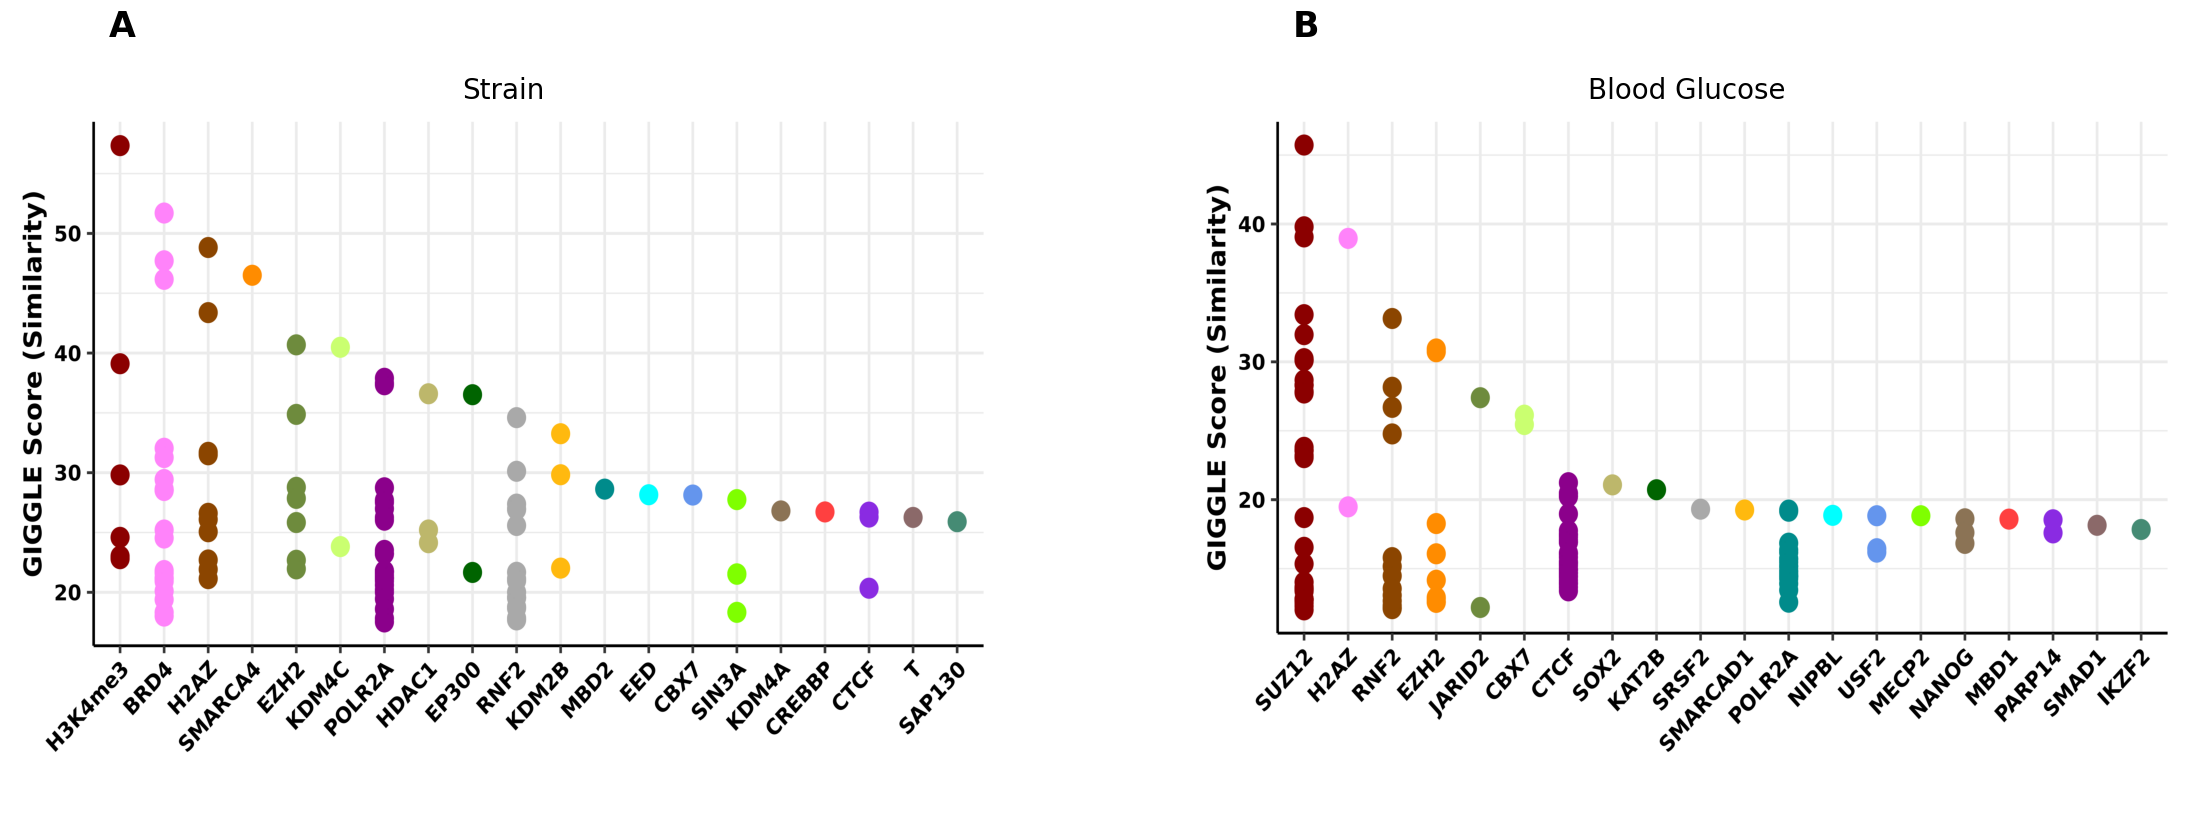

In [97]:
%matplotlib inline

# this is trial and error, unfortunately
'''
2000 for 2
3500 for 3/4
5000 for 5/6
'''
fig_w = 2800
fig_h = 2000

# generate cistrome plots by trait
get_cistrome(cistrome_formatted, fig_w, fig_h)